In [30]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Preparación de datos

In [6]:
df_esios = pd.read_csv('data_training/esios_previsiones_d+1.csv')
df_esios['Date'] = pd.to_datetime(df_esios['Date']).dt.date

# Datetime de inicio del periodo
df_esios['Datetime'] = pd.to_datetime(df_esios['Date']) + pd.to_timedelta(df_esios['Hour'] - 1, unit='h')

df_esios

,indicator_id,Date,Hour,geo_id,value,Datetime
0,1775,2023-01-01,1,8741,20059.80,2023-01-01 00:00:00
1,1775,2023-01-01,2,8741,19380.30,2023-01-01 01:00:00
2,1775,2023-01-01,3,8741,18523.80,2023-01-01 02:00:00
3,1775,2023-01-01,4,8741,17588.30,2023-01-01 03:00:00
4,1775,2023-01-01,5,8741,16834.50,2023-01-01 04:00:00
...,...,...,...,...,...,...
87474,600,2025-06-30,20,3,111.38,2025-06-30 19:00:00
87475,600,2025-06-30,21,3,135.00,2025-06-30 20:00:00
87476,600,2025-06-30,22,3,175.01,2025-06-30 21:00:00
87477,600,2025-06-30,23,3,157.00,2025-06-30 22:00:00


In [7]:
df_esios_clean = df_esios[['Datetime', 'indicator_id', 'value']].copy()
df_esios_clean.drop_duplicates(subset=['Datetime', 'indicator_id'], keep='first', inplace=True)

df_esios_pivot = df_esios_clean.pivot(
    index='Datetime',
    columns='indicator_id',
    values='value'
).reset_index()

df_esios_pivot

indicator_id,Datetime,600,1775,1777,1779
0,2023-01-01 00:00:00,0.00,20059.8,10266.8,0.0
1,2023-01-01 01:00:00,0.00,19380.3,10116.5,0.0
2,2023-01-01 02:00:00,0.00,18523.8,9954.0,0.0
3,2023-01-01 03:00:00,0.00,17588.3,9816.0,0.0
4,2023-01-01 04:00:00,0.00,16834.5,9625.5,0.0
...,...,...,...,...,...
21883,2025-06-30 19:00:00,111.38,NaN,NaN,NaN
21884,2025-06-30 20:00:00,135.00,NaN,NaN,NaN
21885,2025-06-30 21:00:00,175.01,NaN,NaN,NaN
21886,2025-06-30 22:00:00,157.00,NaN,NaN,NaN


In [8]:
df_input = df_esios_pivot.copy()

df_input['Year'] = df_input['Datetime'].dt.year
df_input['Month'] = df_input['Datetime'].dt.month
df_input['Day_of_Week'] = df_input['Datetime'].dt.dayofweek
df_input['Hour'] = df_input['Datetime'].dt.hour

dicc_indicators = {1775: 'demanda', 1777: 'gen_eolica', 1779: 'gen_fotovoltaica', 600: 'MD'}

df_input.rename(columns=dicc_indicators, inplace=True)
df_input.index = df_input['Datetime']

df_input.drop(columns=['Datetime'], inplace=True)
df_input

indicator_id,MD,demanda,gen_eolica,gen_fotovoltaica,Year,Month,Day_of_Week,Hour
Datetime,,,,,,,,
2023-01-01 00:00:00,0.00,20059.8,10266.8,0.0,2023,1,6,0
2023-01-01 01:00:00,0.00,19380.3,10116.5,0.0,2023,1,6,1
2023-01-01 02:00:00,0.00,18523.8,9954.0,0.0,2023,1,6,2
2023-01-01 03:00:00,0.00,17588.3,9816.0,0.0,2023,1,6,3
2023-01-01 04:00:00,0.00,16834.5,9625.5,0.0,2023,1,6,4
...,...,...,...,...,...,...,...,...
2025-06-30 19:00:00,111.38,NaN,NaN,NaN,2025,6,0,19
2025-06-30 20:00:00,135.00,NaN,NaN,NaN,2025,6,0,20
2025-06-30 21:00:00,175.01,NaN,NaN,NaN,2025,6,0,21


In [10]:
df_input['MD_lag_24'] = df_input['MD'].shift(24)
df_input['MD_lag_48'] = df_input['MD'].shift(48)

df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21888 entries, 2023-01-01 00:00:00 to 2025-06-30 23:00:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MD                21885 non-null  float64
 1   demanda           21862 non-null  float64
 2   gen_eolica        21862 non-null  float64
 3   gen_fotovoltaica  21862 non-null  float64
 4   Year              21888 non-null  int32  
 5   Month             21888 non-null  int32  
 6   Day_of_Week       21888 non-null  int32  
 7   Hour              21888 non-null  int32  
 8   MD_lag_24         21861 non-null  float64
 9   MD_lag_48         21837 non-null  float64
dtypes: float64(6), int32(4)
memory usage: 1.5 MB


### Limpieza de datos

In [11]:
df_input = df_input.dropna(axis=0)
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21805 entries, 2023-01-03 00:00:00 to 2025-06-30 00:00:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MD                21805 non-null  float64
 1   demanda           21805 non-null  float64
 2   gen_eolica        21805 non-null  float64
 3   gen_fotovoltaica  21805 non-null  float64
 4   Year              21805 non-null  int32  
 5   Month             21805 non-null  int32  
 6   Day_of_Week       21805 non-null  int32  
 7   Hour              21805 non-null  int32  
 8   MD_lag_24         21805 non-null  float64
 9   MD_lag_48         21805 non-null  float64
dtypes: float64(6), int32(4)
memory usage: 1.5 MB


### Split train - test

In [ ]:
# Opcion 1: Aleatorio
X_train, X_test, y_train, y_test = train_test_split(
    df_input.drop(columns=['MD'], axis=1),
    df_input['MD'],
    test_size=0.2,
    random_state=8
)

# Opcion 2: Elegimos una fecha de separacion
split_date = dt.datetime(2025, 4, 30, 23, 0)
X = df_input.drop(columns=['MD'], axis=1)
y = df_input['MD']
X_train, y_train = X[:split_date], y[:split_date]
X_test, y_test = X[split_date + dt.timedelta(hours=1):], y[split_date + dt.timedelta(hours=1):]

### Modelo Random Forest

In [20]:
model = Pipeline([
    ('scaler', StandardScaler()),      # Escalado de características
    ('regressor', RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ))
])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

MAE: 13.89
RMSE: 19.57


In [29]:
y_comp_df = y_test.to_frame(name='y_test')
y_comp_df['y_pred'] = y_pred.round(2)
y_comp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1441 entries, 2025-05-01 00:00:00 to 2025-06-30 00:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_test  1441 non-null   float64
 1   y_pred  1441 non-null   float64
dtypes: float64(2)
memory usage: 33.8 KB


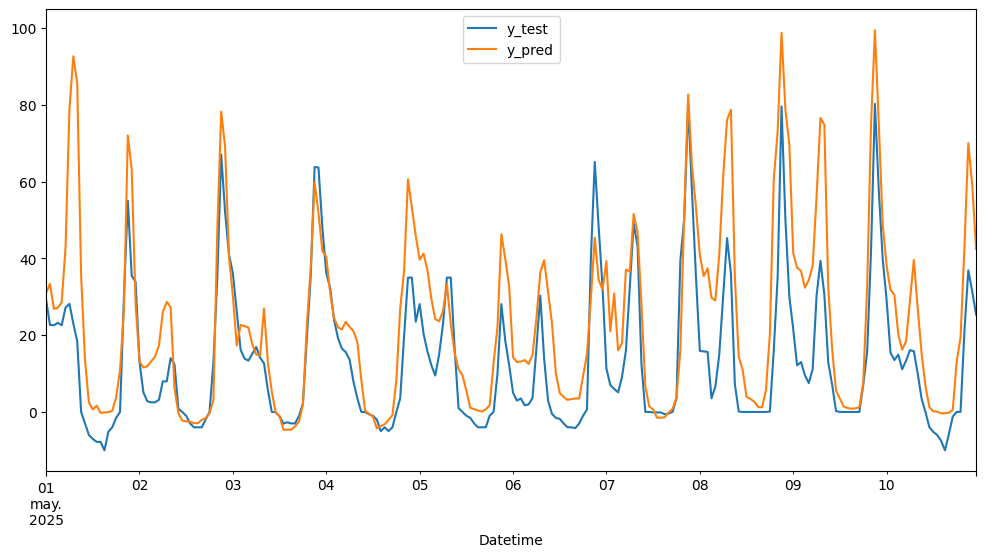

In [33]:
y_comp_df[:(24*10)].plot(figsize=(12, 6))
plt.show()